In [1]:
import numpy as np
import tensorflow as tf

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [2]:
# Size of dataset
print(len(train_data))
print(len(train_labels))

8982
8982


## Explore the data

The dataset comes preprocessed: each example is an array of integers representing the words of the newswires. The text of newswires have been converted to integers, where each integer represents a specific word in a dictionary. Each label is an integer value between 0 and 45, classifying different types of newswires.

In [3]:
print(train_data[0])
print(train_labels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [4]:
len(train_data[0]), len(train_data[1])

(87, 56)

### Decoding the first integer sequence back into sequences¶

In [5]:
#word_index is a dictionary mapping words to an integer index
word_index = tf.keras.datasets.reuters.get_word_index()

#We reverse it, mapping integer indices to words
reverse_word_index = dict ([(value,key) for (key,value) in word_index.items()])

#We decode the review, note that our indices are offset by 3, 
#because 0,1 and 2 are reversed indices for "padding", "start of sequence", and "unknown".
decoded_newswires = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [6]:
decoded_newswires

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [7]:
train_labels[0]

3

In [8]:
print('categories of train labels ',min(train_labels),':',max(train_labels))

categories of train labels  0 : 45


## Prepare the Data

The newswires (the arrays of integers) must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

Here we shall use the first approach.

### Encoding the integer sequeneces into a binary matrix

In [9]:
def vectorize_sequences(sequences, dimension =10000):
    #Create an all-zero matrix of shape (len(sequences), dimensions)
    results = np.zeros((len(sequences), dimension))
    for i,sequence in enumerate(sequences):
        results[i, sequence] = 1. #set specific indices of results[i] to 1s
    return results

#Our vectorized training data
X_train = vectorize_sequences(train_data)

#Our vectorized test data
X_test = vectorize_sequences(test_data)

### One-hot encoding the labels

In [10]:
from tensorflow.keras.utils import to_categorical

#vectorized training labels
y_train = to_categorical(train_labels)

#vectorized test labels
y_test = to_categorical(test_labels)

### Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000,)))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(46, activation = 'softmax'))
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0830 14:43:19.254490 4321863104 deprecation.py:506] From /Users/zohebabai/anaconda/envs/TensorflowProjects/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Categorical_crossentropy minimizes the distance between the probability distributions output by the network, and the true distribution of the targets.

In [12]:
# Setting aside validation set
X_val = X_train[:1000]
partial_X_train = X_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [13]:
# learning rate schedule
import math
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lrate = 1e-03
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

history = model.fit(partial_X_train, partial_y_train,
                    epochs=50, batch_size= 512,
                    validation_data= (X_val, y_val),
                    callbacks=[LearningRateScheduler(step_decay)])

Train on 7982 samples, validate on 1000 samples
Epoch 1/50
7982/7982 [==============================] - 2s 274us/sample - loss: 3.1741 - acc: 0.3434 - val_loss: 2.1972 - val_acc: 0.4940
Epoch 2/50
7982/7982 [==============================] - 1s 142us/sample - loss: 1.8814 - acc: 0.5288 - val_loss: 1.6288 - val_acc: 0.5940
Epoch 3/50
7982/7982 [==============================] - 1s 145us/sample - loss: 1.5187 - acc: 0.6329 - val_loss: 1.4393 - val_acc: 0.6650
Epoch 4/50
7982/7982 [==============================] - 1s 187us/sample - loss: 1.2781 - acc: 0.7006 - val_loss: 1.3046 - val_acc: 0.7080
Epoch 5/50
7982/7982 [==============================] - 1s 164us/sample - loss: 1.0871 - acc: 0.7368 - val_loss: 1.2527 - val_acc: 0.7140
Epoch 6/50
7982/7982 [==============================] - 1s 168us/sample - loss: 0.9828 - acc: 0.7529 - val_loss: 1.2218 - val_acc: 0.7210
Epoch 7/50
7982/7982 [==============================] - 1s 153us/sample - loss: 0.8835 - acc: 0.7760 - val_loss: 1.1948 - va

### Plotting the training and validation loss 

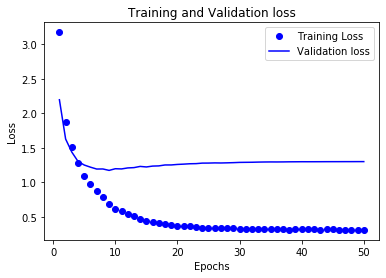

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

acc= history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

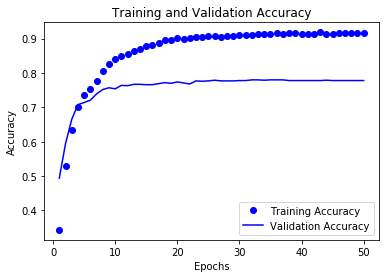

In [15]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Results

In [16]:
results = model.evaluate(X_test, y_test)
results

2246/2246 [==============================] - 0s 154us/sample - loss: 1.4335 - acc: 0.7600


[1.4335079169761678, 0.7600178]